## Setup environment

In [2]:
import matplotlib.pyplot as plt

from simulators.grid_world.grid_world import SimpleGridWorld, simulate_policy
from simulators.grid_world import GAMMA, HORIZON

simple_env = SimpleGridWorld()

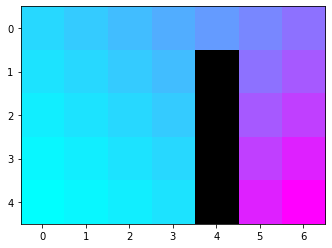

In [4]:
from algorithms.VI_dynamic_programming import value_iteration

Q_expert, expert_policy = value_iteration(simple_env.P, simple_env.R, GAMMA)

# Uncomment if you want to simulate the policy
# simulate_policy(expert_policy, "../../videos/simple_grid_world/expert.mp4", simple_env, HORIZON)

V_expert = Q_expert.max(axis=1)
img = simple_env.get_layout_img(V_expert)    
plt.imshow(img)
plt.show()

In [8]:
import numpy as np


class ReplayBuffer:
    def __init__(self, env, epsilon_decay, gamma, regularisor_bellmann):
        self.env = env
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.regularisor_bellmann = regularisor_bellmann

        self.size_feature = env.get_feature(0, 0).shape[0]

        self.buffer = []

        self.A = None  # Grad matrix
        self.b = None  # Grad matrix

    def collect_samples(self, n_samples, w, trajectory):
        state = self.env.initial_state_distribution

        self.env.reset()
        terminal = False

        for idx_sample in range(n_samples):
            if not trajectory:
                state = np.random.choice(self.env._states)

                while self.env.is_terminal(state):
                    state = np.random.choice(self.env._states)

                self.env.state = state
            elif terminal:  # Trajectory case
                self.env.reset()

            # Policy improvement
            if np.random.random() < self.epsilon_decay(len(self.buffer)):
                action = np.random.choice(self.env._actions)
            else:
                action = np.argmax([self.env.get_feature(state, action) @ w for action in self.env._actions])

            next_state, reward, terminal, _ = self.env.step(action)
            next_action = np.argmax([self.env.get_feature(next_state, action) @ w for action in self.env._actions])

            self.buffer.append((state, action, reward, next_state, next_action))
            state = next_state

    def compute_grad_matrices(self):
        features = np.zeros((len(self.buffer), self.size_feature))
        next_features = np.zeros((len(self.buffer), self.size_feature))
        rewards = np.zeros(len(self.buffer))

        for idx_sample, (state, action, reward, next_state, next_action) in enumerate(self.buffer):
            features[idx_sample] = self.env.get_feature(state, action)
            next_features[idx_sample] = self.env.get_feature(next_state, next_action)
            rewards[idx_sample] = reward

        inverse_matrix = np.linalg.inv(
            features.T @ features + self.regularisor_bellmann * len(self.buffer) * np.eye(self.size_feature)
        )

        self.A = np.eye(self.size_feature) - self.gamma * inverse_matrix @ features.T @ next_features
        self.b = inverse_matrix @ features.T @ rewards


def lstd(env, n_samples_per_iteration, regularisor, regularisor_bellmann, trajectory=False, max_iteration=10, tol=1e-1):
    from algorithms.epsilon_greedy import epsilon_decay
    from simulators.grid_world import GAMMA

    replay_buffer = ReplayBuffer(env, epsilon_decay, GAMMA, regularisor_bellmann)

    w = np.random.random(replay_buffer.size_feature)

    for iteration in range(max_iteration):
        # Exploration
        replay_buffer.collect_samples(n_samples_per_iteration, w, trajectory)
        replay_buffer.compute_grad_matrices()

        # Evaluation
        grad = float("inf") * np.ones(w.shape)

        while np.linalg.norm(grad) < tol:
            grad = np.zeros(w.shape)

            for sample in replay_buffer.buffer:
                feature = env.get_feature(sample[0])
                grad += feature.T @ (replay_buffer.A @ w + replay_buffer.b) @ replay_buffer.A.T @ feature

            grad = grad / len(replay_buffer.buffer) + regularisor * w

            w -= regularisor * grad

        # Improvement
        # Done when samples are collected.

    Q = np.zeros((env.S, env.A))

    for state in env._states:
        for action in env._actions:
            Q[state, action] = env.get_feature(state, action) @ w

    return Q, np.argmax(Q, axis=1)

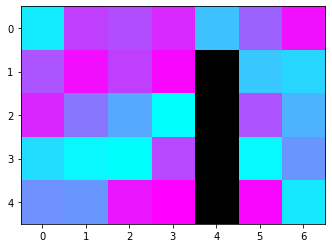

In [15]:
# from algorithms.LSTD import lstd

n_samples_per_iteration = 100
regularisor = 0.1
regularisor_bellmann = 0.1
max_iteration = 10
trajectory = False

Q_lstd, lstd_policy = lstd(simple_env, n_samples_per_iteration, regularisor, regularisor_bellmann, trajectory=trajectory, max_iteration=max_iteration, tol=1e-5)

# Uncomment if you want to simulate the policy
# simulate_policy(lstd_policy, "../../videos/simple_grid_world/lstd.mp4", simple_env, HORIZON)

V_lstd = Q_lstd.max(axis=1)
img = simple_env.get_layout_img(V_lstd)    
plt.imshow(img)
plt.show()
